In [87]:
import pandas as pd
import numpy as np
import pickle

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
#Uncomment the line below to install stanza
#!pip install stanza

In [90]:
from util import spacy_get_sents, stanza_get_sents, spacy_tokenize_text, stanza_tokenize_text, get_texts

In [91]:
from util import get_tokens_dict, common_tokens

# Data collection

For our further inverstigations we will choose 100 texts from "Writers" category that we previously stored:

In [92]:
texts = get_texts(source_type='folder', path='Writers', token_type='file', n=100)

Below we can see the sample of 5 files from the dataset:

In [93]:
texts[:5]

['Anne Von Bertouch, (29 June 1915 – 31 March 2003) was an Australian art dealer, author, environmentalist and director of the Von Bertouch Galleries in Newcastle, New South Wales, believed to be the first commercial gallery outside a capital city in Australia. Biography Born Anne Catherine, to parents Jean (née Duff) and George Whittle on 29 June 1915 in Eastwood, New South Wales, she was educated at Sydney Girls High School and Armidale Teachers College. After teacher training her first posting was at Adamstown Infants School in the 1930s. She married Roger Von Bertouch in 1939. In 1941 she was the organiser of a National Fitness Camp for girls at Broken Bay, New South Wales.She and Roger moved to Tasmania, where they taught and she studied at Hobart Technical College. In 1942 she performed modern interpretive dance at a Town Hall concert in Hobart organised by the Australian Broadcasting Commission Patriotic Committee as a fundraiser on Allies\' Appeal Day. She danced also in Hobart

# Sentence segmentation

For our selected 100 articles we will perform sentence tokenization using Spacy and Stanza.
Each file will be separated into sentences separately.

In [94]:
# Segment all articles using Spacy
spacy_sents = [spacy_get_sents(x) for x in texts]

In [95]:
# The following code needs to be uncommented if you would like to run Stanza segmentation for the first time
""" 
stanza_sents = [stanza_get_sents(x) for x in texts]
"""

# Due to long runtime, we stored the results of Stanza segmentation in a file.
# The following code loads Stanza sentence segmentation:
with open('SpacyStanza/stanza_sents.pickle', 'rb') as f:
    stanza_sents = pickle.load(f)

We can now show the number of sentences calculated by each library for our articles:

In [96]:
# Create a DF to compare sentence count per article
sents_df = pd.DataFrame(columns=['Spacy', 'Stanza'])

# Calculate sentence number per article 
sents_df.Spacy = list(map(lambda x: len(x), spacy_sents))
sents_df.Stanza = list(map(lambda x: len(x), stanza_sents))

sents_df

,Spacy,Stanza
0,107,95
1,37,33
2,8,9
3,35,27
4,28,29
...,...,...
95,32,30
96,21,11
97,18,17
98,7,7


We can look at the stats for all articles, it appears that Spacy on average finds more sentences:

In [97]:
sents_df.describe()

,Spacy,Stanza
count,100.000000,100.000000
mean,30.770000,28.230000
std,26.211978,24.465129
min,3.000000,3.000000
25%,13.000000,11.000000
50%,25.000000,21.500000
75%,37.000000,33.250000
max,155.000000,143.000000


Below we can see the total number of sentences recognized by the both libraries:

In [98]:
sents_df.sum()

Spacy     3077
Stanza    2823
dtype: int64

$\color{red}{\text{**Bonus**}}$


We can notice that overall Stanza splits into sentences less frequently than Spacy does.

We can confirm it using a t-test. Since the tokenization by Spacy and Stanza are performed on the same articles, we will consider the samples to be dependent. Let's set p-value to be < 0.05.



$H_{0}$: Average number of sentences per article generated by Spacy and Stanza is the same.

$H_{1}$: Average number of sentences per article generated by Spacy and Stanza is the same.


In [99]:
from scipy.stats import ttest_rel

In [100]:
ttest_rel(sents_df.Spacy, sents_df.Stanza)

TtestResult(statistic=4.36851507267565, pvalue=3.085063323539573e-05, df=99)

Since p-value is very small we can reject the null hypothesis, and accept the $H_{1}$. And since the value of statistic is positive, we can accept the theory that average of Spacy sentences per article is higher than Stanza.

_____________

Now we can find all unique sentences that both recognize.
First we can look at the number shared sentences per article:

In [101]:
# Make a set of unique sentences for each article for both Spacy and Stanza.
# Find the intersection = these are sentences recognized by both libraries.

shared_sents_per_article = list(map(lambda x,y: set(x).intersection(set(y)), spacy_sents, stanza_sents))

# Create a DF where `shared_sents` is a set of shared sentences per article recognized by segmentation 
# of both libraries and `count` is the length of this set
shared_sents_per_article_df = pd.DataFrame(columns=['shared_sents', 'count'])
shared_sents_per_article_df['shared_sents'] = shared_sents_per_article
shared_sents_per_article_df['count'] = [len(x) for x in shared_sents_per_article]
shared_sents_per_article_df

,shared_sents,count
0,"{She and Roger moved to Tasmania, where they t...",68
1,{His doctoral work explores performance and de...,24
2,{He lost both legs and one arm when an Improvi...,7
3,"{Maurits Sabbe, born Maurice Charles Marie Gui...",12
4,{He grew up in a sporting household and was en...,27
...,...,...
95,{These articles were couched in highly apocaly...,26
96,{Zechariah ben Judah Aghmati (Hebrew: זכריה אג...,10
97,{This was a reward for having in the previous ...,12
98,"{The author of 270 articles, two monographs, o...",7


Below is the overall count of shared sentences:

In [102]:
total_sp_sent = sents_df.sum()['Spacy']
total_st_sent = sents_df.sum()['Stanza']
total_shared = shared_sents_per_article_df['count'].sum()

print(f"""
    Total Spacy sentences: {total_sp_sent}
    Total Stanza sentences: {total_st_sent}
    Shared sentences: {total_shared}
    Percentage of shared sentences for Spacy: {100*total_shared/total_sp_sent:.2f}%
    Percentage of shared sentences for Stanza: {100*total_shared/total_st_sent:.2f}%""")


    Total Spacy sentences: 3077
    Total Stanza sentences: 2823
    Shared sentences: 2263
    Percentage of shared sentences for Spacy: 73.55%
    Percentage of shared sentences for Stanza: 80.16%


We can also have a look at what different articles both libraries found looking at the first mismatched sentence pair 
for each article:

In [103]:
def get_first_mismatched_sent_pair(sp_sents, st_sents):
    n = len(sp_sents)
    m = len(st_sents)
    
    # Go through the array of sentences for both Spacy and Stanza till the end of smallest of them.
    for i in range(min(n, m)):
        # When we reach the first mismatch, print the sentences.
        if sp_sents[i] != st_sents[i]:
            print(f'Spacy sentence: {sp_sents[i]} \n\n'
            f'Stanza sentence: {st_sents[i]}\n'
            '_______________')
            return sp_sents[i], st_sents[i]
    
    # If there was no mismatch during the array traversal, then all the sentences were tokenized together.
    print('Text segmentized into sentences in the same way.\n_______________')
    return None

for i, pair in list(enumerate(zip(spacy_sents, stanza_sents)))[:20]:
    print(f'Article: {i}\n\n')
    get_first_mismatched_sent_pair(pair[0], pair[1])

Article: 0


Spacy sentence: She danced also in Hobart's Opera And Ballet Festival for International Week in 1945.Intending to develop land and to pursue their artistic interests, they moved to Mungo Brush in the Myall Lakes, New South Wales, in 1951 or 1954, living a subsistence existence from prawn fishing and trading their home-grown produce, and were appointed Honorary Rangers there in 1955 under the Wild Flowers and Native Plants Protection Act. 

Stanza sentence: She danced also in Hobart's Opera And Ballet Festival for International Week in 1945.
_______________
Article: 1


Spacy sentence: ISBN 9782844096265, 

Stanza sentence: ISBN 9782844096265, ASIN B07TTX6ZHQ
_______________
Article: 2


Spacy sentence: He successfully underwent a ground-breaking bilateral arm transplant in August 2016.Peck wrote a book, Rebuilding Sergeant Peck: How I Put Body and Soul Back Together After Afghanistan, that was released on May 7, 2019. 

Stanza sentence: He successfully underwent a ground-b

From the sample we see above we can note the following behavior for sentence tokenization for Spacy and Stanza:
- If there is a missing space before a period, separating sentences, Stanza seems to perform sentence segmentation better, e.g `Article 0, 2, 7, 24`...
- In our source material some sections have a title which is not punctuated. Stanza appears to recognize such cases as a separate sentence (correct) more frequently, e.g. `Article 3, 6, 12, 16, 17, 19`...
- However, Stanza seems to be incorrectly splitting a sentence more frequently if there is a punctuation sign followed by a capital letter, e.g. `Article 4, 5, 9, 11, 15, 18`...
- Both libraries struggle (as expected) with sententences that have a lot of non-English words or the input string is not a correct sentence.

______________________

Now we can form a list of shared sentences for all articles combined:

In [104]:
# Convert the sets into arrays and then flatted the 2 array into 1-d array using numpy.concatenate

shared_sents = np.concatenate(list(map(lambda x: list(x), shared_sents_per_article)))

In [105]:
shared_sents[:5]

array(['She and Roger moved to Tasmania, where they taught and she studied at Hobart Technical College.',
       'In 1969, not long after Anne had been injured and suffered a coma in a serious car accident near Morisset the couple separated.',
       'Von Bertouch, Anne (1991).',
       'A dictionary of women artists of Australia.',
       'Finding their block unviable, they moved to Newcastle where they renovated a terrace house.'],
      dtype='<U592')

We can now store the shared sentences into a separate DataFrame and into its own CSV-file:

In [184]:
# Run to generate the DataFrame for this time. If this is uncommented, please uncomment as well the code
# for Stanza tokenization.
"""shared_sents_df = pd.DataFrame(columns=['Sentence'])
shared_sents_df.Sentence = shared_sents"""

# The shared sentences are loaded from a file since we were working with sets and the order changes on each run.
# And due to long runtimes we stored Stanza tokenization results in a file, therefore we need a list of sentences 
# to be in a fixed order.
shared_sents_df = pd.read_csv('SpacyStanza/spacy_stanza_shared_sents.csv', index_col=0)
shared_sents_df 

,Sentence
0,"Anne Von Bertouch, (29 June 1915 – 31 March 20..."
1,ISBN 978-0-9592824-1-2. OCLC 27623615.
2,"Von Bertouch, Anne (1983)."
3,The terraces were purchased by Dr Dick Lees fo...
4,What was it before it was a gallery?.
...,...
2258,"In popular culture In 1999, Komphet Phorncharo..."
2259,"In 1996, Butnakho started to write songs in th..."
2260,"The melody came from the pattern of ""Sao Simue..."
2261,"In 2007, Isan music became very popular in Lao..."


# Tokenization

For the experiment below we will use all the tokens returned by Spacy and Stanza, without filtering any punctuation or spaces.

However, prior to all the analysis texts were cleaned: we removed linebreaks, tabulation and special characters like `|`, `^`, `<`, `>`, `+`, and `=`. These symbols were not returned when we requested the original texts.

We will do the final step of preprocessing and lowercase the text in order to avoid the same word being in vocabulary twice: for different spelling when it's in the beginning or in the middle of a sentence.

For our experiment we will take only the sentences that were previously segmented in the same way by Spacy and Stanza.
For **SharedTokensNosentences** we will stich all the sentences together and separate them by spaces. For **SharedTokensInSentences** we will apply tokenization on the sentences from `shared_sents_df` above.

In [185]:
# Lower the sentences for further tokenization
shared_sents_lower = [s.lower() for s in shared_sents_df.Sentence]

In [186]:
# Create a string for all shared sentences, without any segmentation (for SharedTokensNosentences)
shared_sents_stiched = ' '.join(shared_sents_lower)

##  Vocabulary

To compare vocabularies we will run the comparison on the sentences stiched together into one text.

In [187]:
# Create a set to find unique tokens only
spacy_vocabulary = set(spacy_tokenize_text(shared_sents_stiched, no_filtering=True))

In [188]:
# To run for the first time Stanza tokenization. 
# The codes finds unique Stanza tokens
""" 
stanza_vocabulary = set(stanza_tokenize_text(shared_sents_stiched))

"""

# To load Stanza tokens from a pickle file:
with open('SpacyStanza/stanza_vocabulary.pickle', 'rb') as f:
    stanza_vocabulary = pickle.load(f)

In [189]:
print(f'Spacy vocabulary size: {len(spacy_vocabulary)}\nStanza vocabulary size: {len(stanza_vocabulary)}')

Spacy vocabulary size: 8488
Stanza vocabulary size: 8526


### Shared vocabulary

Shared vocabulary is calculated as intersection of sets of Stanza and Spacy vocabulary:

In [190]:
shared_vocab = spacy_vocabulary.intersection(stanza_vocabulary)

In [191]:
shared_vocab_size = len(shared_vocab)

Size of shared vocabulary:

In [192]:
shared_vocab_size

8264

In [193]:
np.random.choice(list(shared_vocab), size=50)

array(['inviting', 'las', 'las', 'enlarged', 'integrates', 'tatler',
       '1962–63', 'bolsa', 'radical', 'daughters', '1960', 'virradat',
       'indian', 'woman', 'center', 'organist', 'hertfordshire', 'soren',
       'rikkyo', 'contested', 'melody', 'altan', 'falu', 'عوض', 'ruffled',
       'practiced', 'mother', 'intense', 'possible', 'nasheed', 'hodgson',
       'declaration', 'längenfeld', 'according', 'mielau', 'abf', '49',
       'mike', 'voorhoeve', 'unconventional', 'm.', 'argument', 'procyk',
       'roale', 'onward', '"', 'iris', 'drawing', 'ras', 'takween'],
      dtype='<U19')

From the sample above we can observe that both libraries seem to agree on tokenizing a wide range of words:
- Common words like `an`, `egg`, `there`, `having` are present in the shared vocabulary.
- Foreign to English words like `bunyan`, `stanitsa`, `lhadj` are also present in the shared vocabulary.
- We can as well see some Named Entities like dates and locations
- We can as well see an incorrect lemma `ṛṛays` (presumably a part of `arrays`) which was produced by both libraries.
- ...

### Spacy-only vocabulary

In [194]:
spacy_only_vocab = spacy_vocabulary.difference(stanza_vocabulary)
for w in spacy_only_vocab:
    print(w, end=', ')

heiress, 480–44, eck, 1989–1991, vol, yellow, 1998–2002, kwan, 39–40, ¡, esq, 2019–20, 1793–1869, 323, l.c, semitism, turn, n.s.w, bmj.319.7216.1031, ph.d, ,(1898, and/or, 1758, 401, m.a, 8392, 293, 1785–1863, zu'bi, awardee, 905237, 1882–1956, 1912–1928, 521, fc, vatican, doi:10.1136, 1810–1860, u'uqiank'uuh, 1943–24, faingata'a, eminent, χρήστος, 1909–1910, suzuki, 313, 53, editors, ):, covid-19, imperialism, jr, obi, 1990–2008, nesanice/, 1885–1900, p.j,  , 1935–37, 1980–84, madison, ethno, co, 0, m.r.c.p, liechtenstein, colonialism, 9592824, 1996–2000, ju, 1476679488, 1442252813, philosophy-, semitic, بدقت, 1804–1856, 1031–1034, 1868–1936, 1937–39, f.r.c.p, 25–28, t, t.c, 1950/1951, 35–6, semi, kishinev, art;"i, 1848–1905, 2001–2011, 9695188, pre, feudal, 605, isl, multi, hada/, 09, s.s, 23833, cola, a$1.6, e, 1804–1871, 1877–1951,   , 78442, fl, j.d, semite, kyoto, 1795–1864, 1766–1830, 2008–13, 95–96, instrumentalist, re, inst, u'uqinak'uuh, 1918–1923, 1766–1822, l.r.c.s, d.l, bi

In the Spacy-only tokens we can see a lot of numbers as well as non-english words (or non-words).

However, surprisingly we can also see some more or less common English words:
- Some words of relatively more formal register of English: `canonical`, `colonialism`, `denominational`, `editors`, `eminent`, `feudal`, `imperialism`, `instrumentalist`...
- Some NE: `kishinev`, `kyoto`, `liechtenstein`, `vatican` (Locations), `suzuki` (Name or Organisation name), `unesco` (Organisation name)...

### Stanza-only vocubulary

In [195]:
stanza_only_vocab = stanza_vocabulary.difference(spacy_vocabulary)
for w in stanza_only_vocab:
    print(w, end=', ')

eck-verlag, ς, co-edited, b.a., fl., e-, ب, –1974, 978-1134068708, lansdowne., anti-apartheid, 1798, 1923-2011, käkikoski's, serbo-croatian, neo-confucian, co-editors, multi-awardee, wisconsin–madison, 84, 1810, asilah, e-book, 월, co-presenter, covid, inst., pjesme, 1868, m.r.c.s., mid-day, otto-, yonsei-, u', tom's, bmj., prof., im, u-turn, anti-feudal, –march, pg., anti-semitic, –1871, ha-ner, bello's, 39, h.c., gysin's, 978-0-9592824-1-2., 978-3-8392-1500, obi-young, –1951, 1031, 978-605-09, 700, 호, anti-love, chp., anti-imperialism, –1830, el-rufai, –2009, semi-autobiographical, –kishinev, m.a., son-, poem–, non-group, nesanice, ruskin's, –2008, 978-3-7349-9223-0, tambo's, t.c., l.r.c.s., –1869, pen-name, 975-293-040-9, 0-521-23833-1, –707, -1980, .ie, j.d., cc., 978-1442252813, pro-government, liechtenstein., –1905, re-enactment, 1923,1986, ph.d., –37, co-editor, 978-976-8097-13-2., invasion`, pre-eminent, 1785, u'uqinak, –40, co-, anti-semite, 978-1476679488, -3865, novo-dmitriev

We can see that Stanza tends tokenize words with prefixes like `co-`, `anti-`, `non-`, `neo-`... as one token, which explains the difference with Spacy on tokenization of words of relatively formal register.

We can se can see that there is the same tendency towards composed words: `pen-name`, `kingdom-based`, `serbo-croatian`...

As for Named Entities, there appears to be a lot of them tokenized together with `'s`: `yusuf's`, `unesco's`, `suzuki's`, `shin's`, `kyoto's`...

## Occurences

To calculate common accurances we will find all tokens produced by both models for a given string and will find tokens that have the same text for both Stanza and Spacy.

For this we will work with raw token entities from Stanza and Spacy to preserve PoS information for the following experiment since PoS information might be changed if a token is taken out of its context.

### Occurences without sentence separation

We will tokenize all stiched sentences together.

In [196]:
no_sent_spacy_tokens = spacy_tokenize_text(shared_sents_stiched, to_string=False, no_filtering=True)

In [197]:
# To run for the first time Stanza tokenization:
""" 
no_sent_stanza_tokens = stanza_tokenize_text(shared_sents_stiched, to_string=False)

"""

# To load Stanza tokens from a pickle file
with open('SpacyStanza/no_sent_stanza_tokens.pickle', 'rb') as f:
    no_sent_stanza_tokens = pickle.load(f)

In [198]:
# Find common tokens between Spacy and Stanza tokenization, looking at all sentences stitched
common_t = common_tokens(no_sent_spacy_tokens, no_sent_stanza_tokens)

Some token stats:

In [199]:
print(f"""
Spacy tokens: {len(no_sent_spacy_tokens)}
Stanza tokens: {len(no_sent_stanza_tokens)}
Shared tokens: {len(np.concatenate([x[1] for x in common_t]))}
% of shared tokens in Spacy: {100*len(np.concatenate([x[1] for x in common_t]))/len(no_sent_spacy_tokens):.2f}%
% of shared tokens in Stanza: {100*len(np.concatenate([x[1] for x in common_t]))/len(no_sent_stanza_tokens):.2f}%

"""
)


Spacy tokens: 48820
Stanza tokens: 48502
Shared tokens: 48070
% of shared tokens in Spacy: 98.46%
% of shared tokens in Stanza: 99.11%




We will store the results in a dictionary where the key is the word form and the value is another dictionary, storing all seen results for Spacy and Stanza separately.

In [200]:
# Create a dictionary for all shared tokens with no sentence segmentation (SharedTokensNosentences in the task).
# The dictionary takes a wordform as the key and each value contains a separate list for Spacy 
# and Stanza occurrencies.
no_sent_shared_tokens = {x[0][0].text: {'Spacy': x[0], 'Stanza': x[1]} for x in common_t}

In [201]:
# Example of the `no_sent_shared_tokens` structure
no_sent_shared_tokens['record']

{'Spacy': [record, record, record, record, record, record, record],
 'Stanza': [[
    {
      "id": 39,
      "text": "record",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "start_char": 13283,
      "end_char": 13289
    }
  ],
  [
    {
      "id": 17,
      "text": "record",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "start_char": 27303,
      "end_char": 27309
    }
  ],
  [
    {
      "id": 23,
      "text": "record",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "start_char": 95765,
      "end_char": 95771
    }
  ],
  [
    {
      "id": 22,
      "text": "record",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Number=Sing",
      "start_char": 117044,
      "end_char": 117050
    }
  ],
  [
    {
      "id": 12,
      "text": "record",
      "upos": "VERB",
      "xpos": "VB",
      "feats": "VerbForm=Inf",
      "start_char": 159799,
      "end_char": 159805
    }
  

### Occurences with segmented sentences

Now we repeat the experiment but for the separated sentences above:

In [202]:
# Uncomment this cell if you didn't run the cells above:

# shared_sents_df = pd.read_csv('SpacyStanza/spacy_stanza_shared_sents.csv')
# shared_sents_lower = [s.lower() for s in shared_sents_df.Sentence]

In [203]:
# We tokenize each sentence of Shared Sentences separately, creating a list of lists of tokens.
# No tokens are filtered: punctuation and stopwords are all included.
sp_sent_tokens = list(map(lambda x: spacy_tokenize_text(x, no_filtering=True, to_string=False), shared_sents_lower))

In [204]:
# To run for the first time Stanza tokenization:
""" 
st_sent_tokens = list(map(lambda x: stanza_tokenize_text(x, to_string=False), shared_sents_lower))
"""

# To load Stanza tokens from a pickle file
with open('SpacyStanza/st_sent_tockens.pickle', 'rb') as f:
    st_sent_tokens = pickle.load(f)

In [205]:
# Find common tokens for each pair of sentences, returns a list of common token pairs for each sentence.
# Final result is a list of list of tokens.
common_sent_tokens = list(map(lambda x: common_tokens(x[0], x[1]), zip(sp_sent_tokens, st_sent_tokens)))

In [206]:
sent_tokens_df = pd.DataFrame(columns=['Spacy_token_count', 
                                       'Stanza_token_count', 
                                       'Shared_token_count', 
                                       'Spacy_shared_percentage',
                                      'Stanza_shared_percentage'])

In [207]:
# Calculate the token stats per each sentence

sent_tokens_df.Spacy_token_count = list(map(len, sp_sent_tokens))
sent_tokens_df.Stanza_token_count = list(map(len, st_sent_tokens))
sent_tokens_df.Shared_token_count = list(map(len, common_sent_tokens))
sent_tokens_df.Spacy_shared_percentage = 100 * sent_tokens_df.Shared_token_count / sent_tokens_df.Spacy_token_count 
sent_tokens_df.Stanza_shared_percentage = 100 * sent_tokens_df.Shared_token_count / sent_tokens_df.Stanza_token_count 

sent_tokens_df

,Spacy_token_count,Stanza_token_count,Shared_token_count,Spacy_shared_percentage,Stanza_shared_percentage
0,50,50,42,84.000000,84.000000
1,14,5,4,28.571429,80.000000
2,8,8,8,100.000000,100.000000
3,25,27,21,84.000000,77.777778
4,10,9,6,60.000000,66.666667
...,...,...,...,...,...
2258,32,32,29,90.625000,90.625000
2259,16,16,14,87.500000,87.500000
2260,23,23,20,86.956522,86.956522
2261,15,15,14,93.333333,93.333333


Below are average stats for tokens (how many tokens in a sentence are on average provided by Spacy, how many by Stanza, how many are shared etc.):

In [208]:
sent_tokens_df[['Spacy_token_count', 'Stanza_token_count', 'Shared_token_count']].mean()

Spacy_token_count     21.573133
Stanza_token_count    21.438356
Shared_token_count    18.313301
dtype: float64

Total number of shared tokens across all sentences:

In [209]:
print(f"""
Total Spacy tokens: {sent_tokens_df.Spacy_token_count.sum()}
Total Stanza tokens: {sent_tokens_df.Stanza_token_count.sum()}
Total shared tokens: {sent_tokens_df.Shared_token_count.sum()}

Spacy shared tokens %: {sent_tokens_df.Shared_token_count.sum() * 100 /sent_tokens_df.Spacy_token_count.sum()}
Stanza shared tokens %: {sent_tokens_df.Shared_token_count.sum() * 100 /sent_tokens_df.Stanza_token_count.sum()}
""")


Total Spacy tokens: 48820
Total Stanza tokens: 48515
Total shared tokens: 41443

Spacy shared tokens %: 84.88938959442851
Stanza shared tokens %: 85.42306503143358



We have less aligned tokens now, meaning that in the experiment above we might have matched tokens from different sentences.

We will combine all the shared tokens from our sentences into one dictionary of the same structure as above: the keys are wordforms, the values are dictionaries containing arrays of all of the occurences of the wordforms.

Since for PoS analysis for Stanza requires words instead of tokens, we will convert the conversion as well.

In [210]:
# Create a dictionary of wordforms and all shared token occurrencies across all sentences 
# (SharedTokensInSentences in the task). 
#The expected structure of the dictionary is the same as for `no_sent_shared_tokens`
shared_sent_tokens = {}

# Go through each of shared sentences
for sent in common_sent_tokens:
    # Go through every shared token in this sentence
    for word in sent:
        word_text = word[0][0].text
        
        # If the word was not seen in previous sentences add it to the dictionary
        if word_text not in shared_sent_tokens.keys():
            shared_sent_tokens[word_text] = {}
            shared_sent_tokens[word_text]['Spacy'] = []
            shared_sent_tokens[word_text]['Stanza'] = []
        
        # Add Spacy occurrence to the list
        shared_sent_tokens[word_text]['Spacy'].append(word[0][0])
        # Before extending the list convert tokens to words for easier access to PoS information in the following task
        # Add Stanza occurence to the list
        shared_sent_tokens[word_text]['Stanza'].append(list(map(lambda x: x.words[0], word[1]))[0])


Below is an example of how the dictionary will work on an example of one word `chief`.

`shared_sent_tokens['chief']['Spacy']` can be called to get all Spacy tokens and similarly `shared_sent_tokens['chief']['Stanza']` can be called to get all Stanza tokens.

In this example we can see that this word was sometimes categorized as Noun and sometimes as Adjective.

How PoS can be accessed for Spacy:

In [211]:
shared_sent_tokens['chief']['Spacy'][0], shared_sent_tokens['chief']['Spacy'][0].pos_

(chief, 'ADJ')

How PoS can be accessed for Stanza:

In [212]:
shared_sent_tokens['chief']['Stanza'][0], shared_sent_tokens['chief']['Stanza'][0].upos

({
   "id": 5,
   "text": "chief",
   "upos": "ADJ",
   "xpos": "JJ",
   "feats": "Degree=Pos",
   "start_char": 20,
   "end_char": 25
 },
 'ADJ')

_________
**A helper function that would return all Spacy or Stanza UPOS by a wordform:**

In [213]:
# Returns a list of all PoS observed for a wordform. 
# The information is retreived from shared tokens from the shared sentences.

def get_pos(wordform, library):
    if library == 'Spacy':
        return np.array([x.pos_ for x in shared_sent_tokens[wordform][library]])
    elif library == 'Stanza':
        return np.array([x.upos for x in shared_sent_tokens[wordform][library]])
    else:
        raise Exception('The supported library values are: Spacy, Stanza')

In [214]:
# Return a number of occurrencies when a wordform was tokenized in the same way by Spacy and Stanza.

def get_occurence_count(wordform):
    return len(shared_sent_tokens[wordform]['Spacy'])

# Part of Speech

In this section we will compare how Spacy and Stanza generate PoS information.

For this we will re-use the `shared_sent_tokens` (all the tokens of the same text from shared sentences that were generated by both Spacy and Stanza).

## Token stats

First, we can calculate the number of times Spacy and Stanza agree on a token PoS for each token.
The tokens in `shared_sent_tokens` are grouped by the wordform, we will keep the same grouping for the DF:

In [215]:
# The dataframe has total number of occurrencies of a wordform in "Number_occurencies" column.
# Spacy tags and Stanza tags list of UPOS tags for the occurencies. Length of these arrays should be equal to 
# "Number_occurencies".
# Same is the column that would represent the number of times Spacy and Stanza agree on a POS tag for an occurence.

pos_df = pd.DataFrame(columns=['Word', 'Number_occurencies', 'Spacy_tags', 'Stanza_tags', 'Same'])

In [216]:
# Get all the wordforms from the dictionary above
pos_df.Word = shared_sent_tokens.keys()

In [217]:
# Get the occurencies count
pos_df.Number_occurencies = pos_df.Word.apply(lambda x: get_occurence_count(x))

In [218]:
# Get spacy and stanza POS tags

pos_df.Spacy_tags = pos_df.Word.apply(lambda x: get_pos(x, 'Spacy'))
pos_df.Stanza_tags = pos_df.Word.apply(lambda x: get_pos(x, 'Stanza'))

In [219]:
# Number of times an element of Spacy tags array is the same as Stanza tags for each wordform
pos_df.Same = list(map(lambda x: sum(x[0] == x[1]), zip(pos_df.Spacy_tags, pos_df.Stanza_tags)))

In [220]:
pos_df = pos_df.set_index('Word')
pos_df

,Number_occurencies,Spacy_tags,Stanza_tags,Same
Word,,,,
outside,5,"[ADP, ADP, ADP, ADP, ADP]","[ADP, ADP, ADP, ADP, ADV]",4
new,63,"[ADJ, ADJ, ADJ, ADJ, ADJ, ADJ, ADJ, ADJ, PROPN...","[ADJ, ADJ, ADJ, ADJ, ADJ, ADJ, ADJ, ADJ, ADJ, ...",37
commercial,2,"[ADJ, ADJ]","[ADJ, ADJ]",2
australia,17,"[PROPN, PROPN, PROPN, PROPN, PROPN, PROPN, PRO...","[PROPN, PROPN, PROPN, PROPN, PROPN, PROPN, PRO...",16
von,15,"[PROPN, PROPN, PROPN, PROPN, PROPN, PROPN, PRO...","[PROPN, PROPN, PROPN, PROPN, PROPN, PROPN, PRO...",13
...,...,...,...,...
simueang,1,[PROPN],[X],0
songwriting,1,[VERB],[NOUN],0
stopped,1,[VERB],[VERB],1


In [221]:
print(f"""
All shared tokens: {pos_df.Number_occurencies.sum()}
Total tokens with shared PoS: {pos_df.Same.sum()}
Percentage of tokens with shared PoS: {pos_df.Same.sum()*100/pos_df.Number_occurencies.sum()}
""")


All shared tokens: 41443
Total tokens with shared PoS: 36713
Percentage of tokens with shared PoS: 88.58673358588905



## PoS stats

Now we can compare the PoS tags: how frequently a Spacy NOUN is marked as NOUN or other UPOS by Stanza and so on.

For this, first we need to find all unique Spacy and Stanza PoS tags across our tokens.

In [222]:
# Flatten the PoS lists and sort them alphabetically

unique_spacy_pos = sorted(list(set(np.concatenate(pos_df.Spacy_tags))))
unique_stanza_pos = sorted(list(set(np.concatenate(pos_df.Stanza_tags))))

Let's add total numbers for all UPOS for both Spacy and Stanza:

In [223]:
# Create a DF for UPOS cooccurrencies

upos_df = pd.DataFrame(columns=unique_spacy_pos, index=unique_stanza_pos)
# Fill all the cooccurencies with zeros first
upos_df = upos_df.fillna(0)

# For each unique wordform
for w in pos_df.index:
    # Go through the PoS arrays for Spacy and Stanza simultaneously
    for i in range(pos_df.loc[w].Number_occurencies):
        # Get the PoS tags for the occurence that have the same index
        w_spacy_tag = pos_df.loc[w].Spacy_tags[i]
        w_stanza_tag = pos_df.loc[w].Stanza_tags[i]
        # Increase the cooccurrence counter
        upos_df.loc[w_stanza_tag, w_spacy_tag] += 1

# Add totals
upos_df['Total_Stanza'] = upos_df.sum(axis=1)
upos_df.loc['Total_Spacy', :] = upos_df.sum(axis=0)

In [224]:
upos_df

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X,Total_Stanza
ADJ,2645.0,0.0,23.0,0.0,0.0,2.0,0.0,95.0,3.0,0.0,0.0,213.0,0.0,0.0,0.0,0.0,40.0,0.0,3021.0
ADP,1.0,4617.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,26.0,0.0,2.0,0.0,46.0,0.0,0.0,0.0,0.0,4699.0
ADV,7.0,22.0,804.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,3.0,7.0,0.0,124.0,0.0,0.0,1.0,0.0,973.0
AUX,0.0,0.0,0.0,1209.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,1217.0
CCONJ,0.0,0.0,0.0,0.0,1076.0,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1088.0
DET,0.0,0.0,0.0,0.0,0.0,2255.0,1.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2284.0
INTJ,2.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
NOUN,148.0,0.0,22.0,1.0,0.0,0.0,2.0,8286.0,10.0,0.0,1.0,1179.0,0.0,0.0,0.0,0.0,96.0,3.0,9748.0
NUM,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1853.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,4.0,1873.0
PART,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,486.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,493.0


Now we can create a DataFrame that will calculate percentages of a certain Spacy tag being matched with a Stanza tag.

The columns represent Spacy UPOS tags, on the intersection with the rows you can find the percentage of occurences when this UPOS tag was recognized as another (or the same) UPOS tag by Stanza.

In [135]:
spacy_upos_perc_df = round(100* upos_df / upos_df.loc['Total_Spacy']).drop(['Total_Stanza'], axis=1)
spacy_upos_perc_df

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SPACE,SYM,VERB,X
ADJ,87.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0
ADP,0.0,97.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,5.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
ADV,0.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0
AUX,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCONJ,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DET,0.0,0.0,0.0,0.0,0.0,99.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
INTJ,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOUN,5.0,0.0,2.0,0.0,0.0,0.0,17.0,88.0,1.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,3.0,4.0
NUM,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
PART,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


____________

Now we can plot the pie charts for most popular PoS: NOUN, VERB, ADJ, ADV. We will take all the tokens tagged with these PoS, and plot distribution of correspoding Stanza PoS tags.

## NOUN

Below is the plot for all the Stanza tags for the tokens that Spacy tagged `NOUN`:

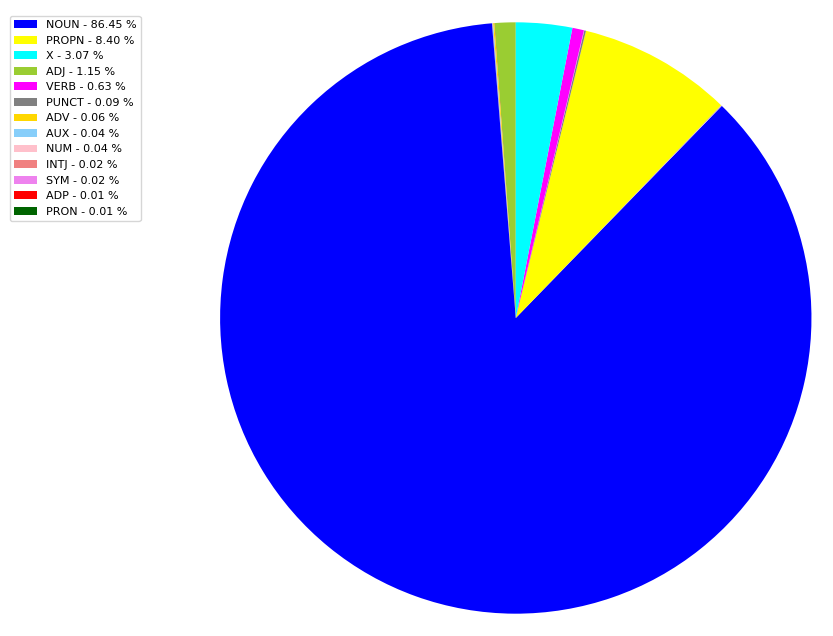

In [188]:
plt.figure(figsize=(8, 8))

data = upos_df.NOUN[upos_df.NOUN > 0][:-1].values
labels = upos_df.NOUN[upos_df.NOUN>0][:-1].index

#define color palette to use
colors =  ['yellowgreen','red','gold','lightskyblue','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan'][:len(data)]

# Create pie chart
perc = 100.*data/data.sum()

patches, texts = plt.pie(data, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, perc)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

## VERB

Below is the plot for all the Stanza tags for the tokens that Spacy tagged `VERB`:

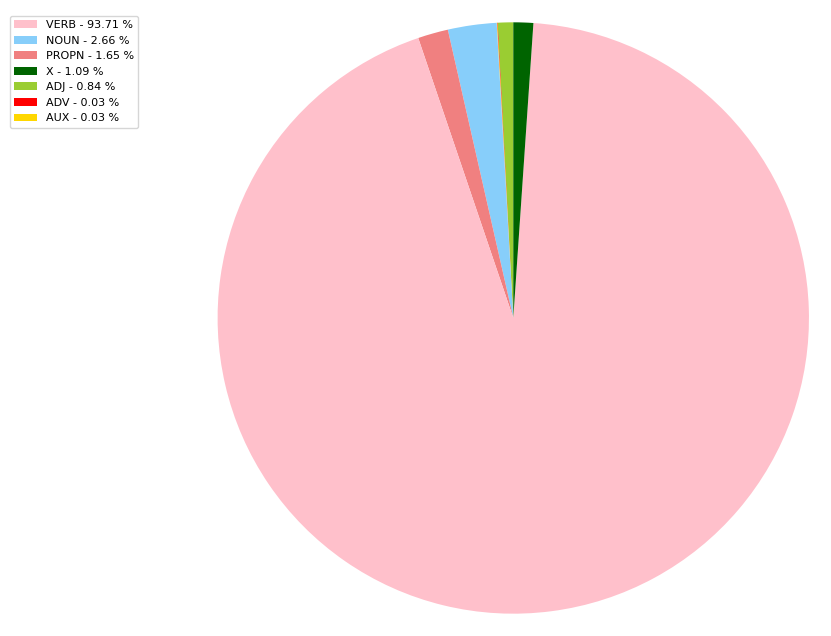

In [189]:
plt.figure(figsize=(8, 8))

data = upos_df.VERB[upos_df.VERB > 0][:-1].values
labels = upos_df.VERB[upos_df.VERB>0][:-1].index

#define color palette to use
colors =  ['yellowgreen','red','gold','lightskyblue','lightcoral','pink', 'darkgreen','yellow','grey','violet','magenta','cyan'][:len(data)]

# Create pie chart
perc = 100.*data/data.sum()

patches, texts = plt.pie(data, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, perc)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

## ADJ

Below is the plot for all the Stanza tags for the tokens that Spacy tagged `ADJ`:

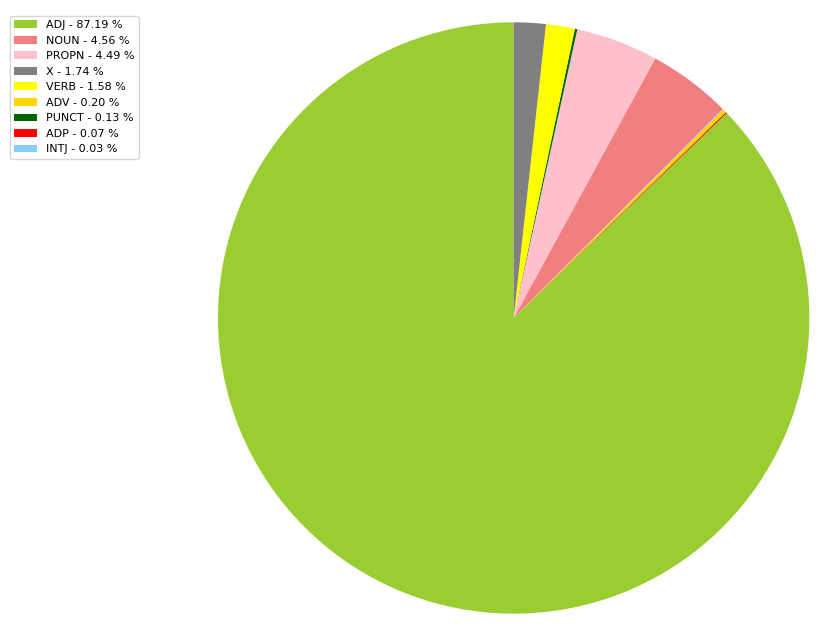

In [190]:
plt.figure(figsize=(8, 8))

data = upos_df.ADJ[upos_df.ADJ > 0][:-1].values
labels = upos_df.ADJ[upos_df.ADJ>0][:-1].index

#define color palette to use
colors =  ['yellowgreen','red','gold','lightskyblue','lightcoral','pink', 'darkgreen','yellow','grey','violet','magenta','cyan'][:len(data)]

# Create pie chart
perc = 100.*data/data.sum()

patches, texts = plt.pie(data, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, perc)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

## ADV

Below is the plot for all the Stanza tags for the tokens that Spacy tagged `ADV`:

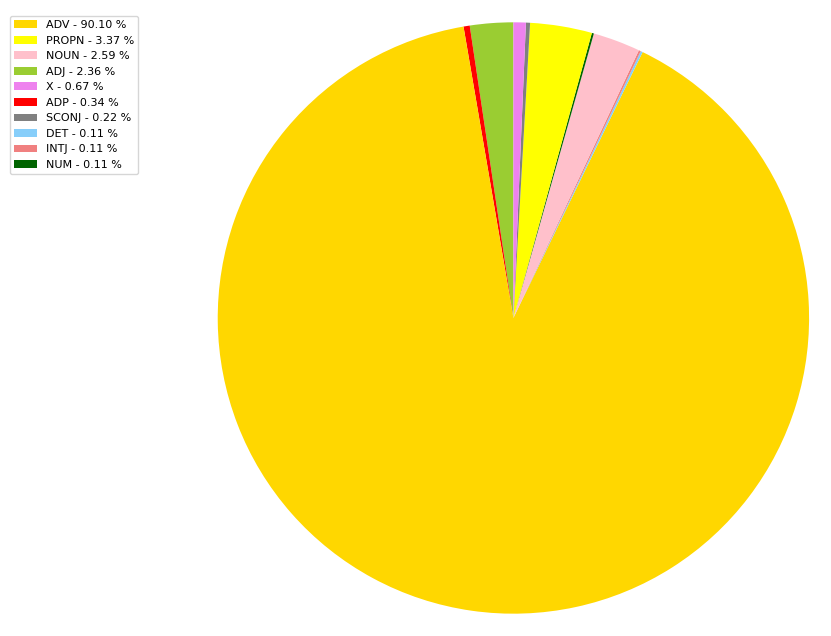

In [191]:
plt.figure(figsize=(8, 8))

data = upos_df.ADV[upos_df.ADV > 0][:-1].values
labels = upos_df.ADV[upos_df.ADV>0][:-1].index

#define color palette to use
colors =  ['yellowgreen','red','gold','lightskyblue','lightcoral','pink', 'darkgreen','yellow','grey','violet','magenta','cyan'][:len(data)]

# Create pie chart
perc = 100.*data/data.sum()

patches, texts = plt.pie(data, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, perc)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, data),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

____________________

$\color{red}{\text{**Bonus**}}$

Below is an investigation of what type of words are getting tagged as 'X' (unrecognized) by one of the libraries but recognized by the other:

In [226]:
X_spacy = []
X_stanza = []

for w in pos_df.index:
    for i in range(pos_df.loc[w].Number_occurencies):
        
        if (pos_df.loc[w].Spacy_tags[i] == 'X') and not(pos_df.loc[w].Stanza_tags[i] == 'X'):
            X_spacy.append(w)
        if (pos_df.loc[w].Stanza_tags[i] == 'X') and not(pos_df.loc[w].Spacy_tags[i] == 'X'):
            X_stanza.append(w)
len(set(X_spacy)), len(set(X_stanza))

(18, 944)

We can see that there are just 18 unique words that are recognized by Stanza but unrecognized by Spacy, vs 944 (!) that are unrecognized by Stanza but recognized by Spacy.

Words recognized by Stanza but not recognized by Spacy:

In [227]:
list(set(X_spacy))

['2',
 'de',
 'emmanuel',
 '[',
 'garde',
 'i̇htilal',
 '.',
 'ninja',
 'i̇damlar',
 '1',
 'pevec',
 'nichols',
 '1–33',
 '3',
 'newcastle',
 'shalom',
 ']',
 'večernji']

Surprisingly we see some named entities like (`emmanuel`, `newcastle`, etc.) as unrecognized by Spacy.

Since there are over 900 words that are not recognized we will just print random 50 of these words:

In [284]:
np.random.choice(list(set(X_stanza)), size=100)

array(['stanko', 'maimonides', 'srbin', 'žandarm', 'blanca', 'sall',
       'madrid', 'dlaczego', 'kunstpfeifer', 'golf', 'geographischen',
       'penumbra', 'rancière', 'daibosatsu', 'such', 'päivärinta',
       'unamuno', 'chukgu', 'baynahoma', 'mohanty', 'državna', 'bounkerd',
       'von', 'glasnik', 'fagih', 'n.', 'edward', 'khong', 'yamabushi',
       'université', 'e.', 'aldeanas', 'chananel', 'kee', 'haar', 'bund',
       'impresiones', 'uit', 'johan', 'shringarpure', 'wöll', 'husayn',
       'sarbeeb', 'chushiel', 'comunismo', 'beduinentums', 'sürecinde',
       'en', 'burgos', 'dlaczego', 'azaña', 'tim', 'phiromphon', 'npc',
       'fe', 'alle', 'thung', 'filatélica', 'na', 'ibn', 'czyli',
       'kunstpfeifer', 'burgos', 'zetung', 'državna', 'pusat', 'edward',
       'mabuza', 'eléctricos', 'os', 'azerbaycan', 'seonggyungwan',
       'awad', 'especial', 'burgos', 'over', 'máglyatűz', 'aldeanas',
       'beneytez', 'instituts', 'argentino', 'književne', 'ramo',
       'rediv

We can see that most of them are of a foreign origin, but surprisingly there is also `sin`.

However, if we look at `golf` occurence in our shared sentences it is actually in a sentence in Dutch (therefore `X` is explainable).

In [281]:
pos_df.loc['golf']

Number_occurencies          1
Spacy_tags            [PROPN]
Stanza_tags               [X]
Same                        0
Name: golf, dtype: object

In [285]:
for s in shared_sents_df.Sentence:
    if 'golf' in s.lower():
        print(s)

De eerste feministische golf, het huwelijksrecht en de vaderlandse geschiedenis.


We can also look at other foreign words that apparently Spacy assigned a PoS and Stanza marked as `X`.
For example `geographischen` (meaning `geographic` in German):

In [286]:
pos_df.loc['geographischen']

Number_occurencies          1
Spacy_tags            [PROPN]
Stanza_tags               [X]
Same                        0
Name: geographischen, dtype: object

In [287]:
for s in shared_sents_df.Sentence:
    if 'geographischen' in s.lower():
        print(s)

Das Aulflosungsprozess des Beduinentums in Irak, in: Abhandlung des geographischen Insititut Anthropo-geographischie.


Both examples are a full sentence in a foreign language, however, Spacy attempts to categorize all of it as PROPN 